In [1]:
from theano.sandbox import cuda

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce 920M (0000:01:00.0)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

*R

In [99]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -q ml-latest-small.zip
!mv ml-latest-small/* data/ml-small/
!rm -r ml-latest-small/ ml-latest-small.zip

wget: /home/fei/miniconda3/envs/py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /home/fei/miniconda3/envs/py2/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /home/fei/miniconda3/envs/py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2017-11-07 21:05:19--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: 'ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 896.75K   262KB/s    in 3.4s    

2017-11-07 21:05:23 (262 KB/s) - 'ml-latest-small.zip’ saved [918269/918269]



## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [71]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [72]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [73]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [74]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [75]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [76]:
ratings.loc[:, 'movieId'] = ratings.movieId.map(movieid2idx)
ratings.loc[:, 'userId'] = ratings.userId.map(userid2idx)

In [77]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [78]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [79]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [80]:
n_factors = 50

In [81]:
np.random.seed = 42

Randomly split into training and validation.

In [82]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [83]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [84]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [85]:
topUsers.head()

userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64

In [86]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [87]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [88]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [21]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [22]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/1
79949/79949 [==============================] - 5s - loss: 9.8370 - val_loss: 4.2628


In [24]:
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/3
79949/79949 [==============================] - 5s - loss: 3.1427 - val_loss: 2.8019
Epoch 2/3
79949/79949 [==============================] - 5s - loss: 2.4200 - val_loss: 2.6006
Epoch 3/3
79949/79949 [==============================] - 5s - loss: 2.2493 - val_loss: 2.5586


In [26]:
model.optimizer.lr=0.001

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/6
79949/79949 [==============================] - 5s - loss: 2.1845 - val_loss: 2.5439
Epoch 2/6
79949/79949 [==============================] - 5s - loss: 2.1468 - val_loss: 2.5407
Epoch 3/6
79949/79949 [==============================] - 5s - loss: 2.1214 - val_loss: 2.5421
Epoch 4/6
79949/79949 [==============================] - 6s - loss: 2.1001 - val_loss: 2.5499
Epoch 5/6
79949/79949 [==============================] - 5s - loss: 2.0798 - val_loss: 2.5535
Epoch 6/6
79949/79949 [==============================] - 5s - loss: 2.0604 - val_loss: 2.5607


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [28]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [29]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [30]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [31]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [32]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/1
79949/79949 [==============================] - 6s - loss: 8.8084 - val_loss: 3.5171


In [34]:
model.optimizer.lr=0.01

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/6
79949/79949 [==============================] - 6s - loss: 2.5929 - val_loss: 2.2853
Epoch 2/6
79949/79949 [==============================] - 6s - loss: 1.9962 - val_loss: 2.0846
Epoch 3/6
79949/79949 [==============================] - 6s - loss: 1.8322 - val_loss: 1.9915
Epoch 4/6
79949/79949 [==============================] - 6s - loss: 1.7387 - val_loss: 1.9188
Epoch 5/6
79949/79949 [==============================] - 6s - loss: 1.6608 - val_loss: 1.8517
Epoch 6/6
79949/79949 [==============================] - 6s - loss: 1.5882 - val_loss: 1.7879


In [36]:
model.optimizer.lr=0.001

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/10
79949/79949 [==============================] - 6s - loss: 1.5178 - val_loss: 1.7192
Epoch 2/10
79949/79949 [==============================] - 6s - loss: 1.4500 - val_loss: 1.6625
Epoch 3/10
79949/79949 [==============================] - 6s - loss: 1.3831 - val_loss: 1.6015
Epoch 4/10
79949/79949 [==============================] - 6s - loss: 1.3164 - val_loss: 1.5511
Epoch 5/10
79949/79949 [==============================] - 6s - loss: 1.2517 - val_loss: 1.5007
Epoch 6/10
79949/79949 [==============================] - 6s - loss: 1.1895 - val_loss: 1.4515
Epoch 7/10
79949/79949 [==============================] - 6s - loss: 1.1311 - val_loss: 1.4071
Epoch 8/10
79949/79949 [==============================] - 6s - loss: 1.0751 - val_loss: 1.3634
Epoch 9/10
79949/79949 [==============================] - 6s - loss: 1.0234 - val_loss: 1.3246
Epoch 10/10
79949/79949 [==============================] - 6s - loss: 0.9727 - val_loss: 1.2894

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/5
79949/79949 [==============================] - 6s - loss: 0.9264 - val_loss: 1.2545
Epoch 2/5
79949/79949 [==============================] - 6s - loss: 0.8825 - val_loss: 1.2247
Epoch 3/5
79949/79949 [==============================] - 7s - loss: 0.8421 - val_loss: 1.1962
Epoch 4/5
79949/79949 [==============================] - 6s - loss: 0.8040 - val_loss: 1.1707
Epoch 5/5
79949/79949 [==============================] - 6s - loss: 0.7700 - val_loss: 1.1476


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [39]:
model.save_weights(model_path+'bias.h5')

In [40]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [41]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.0093]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [42]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [43]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [44]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.31511772, 'Battlefield Earth (2000)'),
 (-0.115462, 'Little Nicky (2000)'),
 (-0.10251138, 'Super Mario Bros. (1993)'),
 (-0.069963813, 'Jaws 3-D (1983)'),
 (-0.033784106, 'Blade: Trinity (2004)'),
 (-0.022225339, 'Spice World (1997)'),
 (-0.012114029, 'Inspector Gadget (1999)'),
 (-0.0056346469, 'Police Academy 6: City Under Siege (1989)'),
 (0.020876264, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.02821655, 'Speed 2: Cruise Control (1997)'),
 (0.051252294, 'Money Train (1995)'),
 (0.052014697, 'Avengers, The (1998)'),
 (0.063273922, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.068473034, 'Road to Wellville, The (1994)'),
 (0.077904679, 'Blair Witch Project, The (1999)')]

In [45]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4297385, 'Rush (2013)'),
 (1.3951685, 'Cyrano de Bergerac (1990)'),
 (1.3568058, 'Harry Potter and the Half-Blood Prince (2009)'),
 (1.3324704, 'Blood Simple (1984)'),
 (1.3306595, "Amores Perros (Love's a Bitch) (2000)"),
 (1.3291016, 'Captain America: The Winter Soldier (2014)'),
 (1.3257159, 'Argo (2012)'),
 (1.3217213, 'Shawshank Redemption, The (1994)'),
 (1.3038077, 'Last King of Scotland, The (2006)'),
 (1.3018897, 'The Theory of Everything (2014)'),
 (1.2998668, 'Gold Rush, The (1925)'),
 (1.293993, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2879901, 'When We Were Kings (1996)'),
 (1.2813119, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.270815, 'My Neighbor Totoro (Tonari no Totoro) (1988)')]

We can now do the same thing for the embeddings.

In [46]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [48]:
fac0 = movie_pca[0]

In [49]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.051596943, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.051456947, 'Usual Suspects, The (1995)'),
 (0.050880279, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.048995942, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.048943043, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.048926946, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.04853547, "Schindler's List (1993)"),
 (0.048255429, 'Shawshank Redemption, The (1994)'),
 (0.047720868, 'Amadeus (1984)'),
 (0.04760934, 'Wallace & Gromit: A Close Shave (1995)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.012272609, 'Mission to Mars (2000)'),
 (-0.011314422, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0098875137, 'Blade: Trinity (2004)'),
 (-0.0094804149, 'Anaconda (1997)'),
 (-0.0089326128, 'Godzilla (1998)'),
 (-0.0088599967, 'Battlefield Earth (2000)'),
 (-0.0079302108, 'Police Academy 3: Back in Training (1986)'),
 (-0.0077796187, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0070800628,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (-0.0059926091, 'Howard the Duck (1986)')]

In [52]:
fac1 = movie_pca[1]

In [53]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [54]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.069215827, 'Annie Hall (1977)'),
 (0.062949114, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.062454842, 'City Lights (1931)'),
 (0.06196782, 'Royal Tenenbaums, The (2001)'),
 (0.06024088, 'Manhattan (1979)'),
 (0.058781762, 'Bringing Up Baby (1938)'),
 (0.05690534, 'Lost in Translation (2003)'),
 (0.056739535, 'Wild Bunch, The (1969)'),
 (0.054463536, 'Brokeback Mountain (2005)'),
 (0.053990014,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)')]

In [55]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1021374, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.088456675, 'Armageddon (1998)'),
 (-0.083770469, 'Stargate (1994)'),
 (-0.075449869, 'X-Men (2000)'),
 (-0.075289458, 'Rock, The (1996)'),
 (-0.074984007, 'Speed (1994)'),
 (-0.070428632, 'True Lies (1994)'),
 (-0.069536343, 'Braveheart (1995)'),
 (-0.068338335, 'Star Trek: Generations (1994)'),
 (-0.067546241, 'Happy Gilmore (1996)')]

In [56]:
fac2 = movie_pca[2]

In [57]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.078519523, 'Sabrina (1995)'),
 (0.072296053, 'Chicken Run (2000)'),
 (0.067303516, 'Legally Blonde (2001)'),
 (0.067301348, 'Elf (2003)'),
 (0.060701653, 'Miss Congeniality (2000)'),
 (0.060050517, '13 Going on 30 (2004)'),
 (0.059126861, 'Chicago (2002)'),
 (0.058814745, 'Bend It Like Beckham (2002)'),
 (0.058722191, 'Lilo & Stitch (2002)'),
 (0.056737699, 'Harry Potter and the Chamber of Secrets (2002)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.13197376, 'Silence of the Lambs, The (1991)'),
 (-0.10247803, 'Fargo (1996)'),
 (-0.1014339, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.098295189, 'Pulp Fiction (1994)'),
 (-0.094567314, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.087923646, 'Eyes Wide Shut (1999)'),
 (-0.082089677, 'True Lies (1994)'),
 (-0.075894892, 'Taxi Driver (1976)'),
 (-0.067711018, 'Jurassic Park (1993)'),
 (-0.06577006, 'Die Hard: With a Vengeance (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [60]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

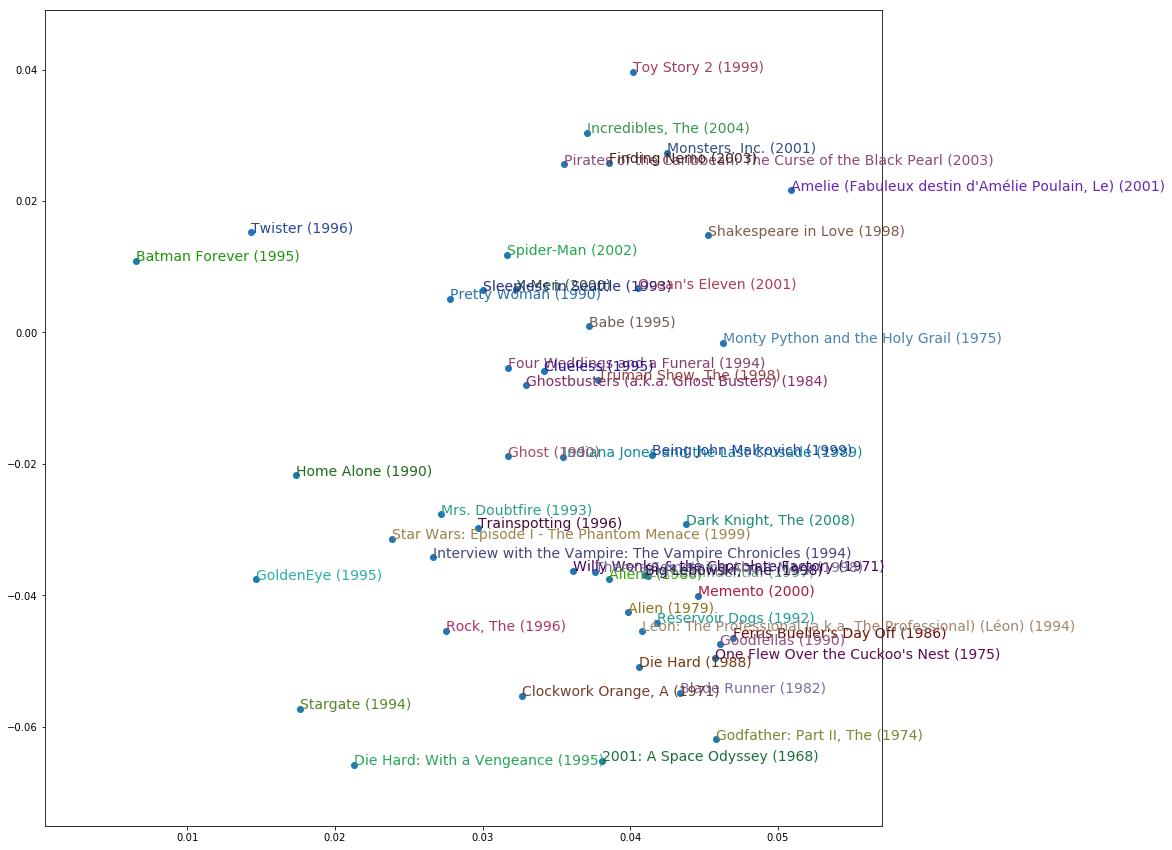

In [61]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [62]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [63]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [64]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79949 samples, validate on 20055 samples
Epoch 1/8
79949/79949 [==============================] - 6s - loss: 2.6531 - val_loss: 0.9444
Epoch 2/8
79949/79949 [==============================] - 6s - loss: 1.5639 - val_loss: 0.8947
Epoch 3/8
79949/79949 [==============================] - 6s - loss: 1.2516 - val_loss: 0.8678
Epoch 4/8
79949/79949 [==============================] - 6s - loss: 1.0469 - val_loss: 0.8549
Epoch 5/8
79949/79949 [==============================] - 6s - loss: 0.9110 - val_loss: 0.8488
Epoch 6/8
79949/79949 [==============================] - 6s - loss: 0.8434 - val_loss: 0.8397
Epoch 7/8
79949/79949 [==============================] - 6s - loss: 0.8170 - val_loss: 0.8398
Epoch 8/8
79949/79949 [==============================] - 6s - loss: 0.8093 - val_loss: 0.8414


This improves on our already impressive accuracy even further!